<img src="header-image-classification.png"/>

# Execution du notebook

Le présent notebook suppose l'arborescence suivante, pour le chargement des données et l'écriture des résultats : 

```bash
├───data
│   ├───processed
│   │   ├───df_tk_res.pkl
│   ├───raw
│   │   └───images/*.jpg
│   └───output
└───notebooks
    ├───1_exploration.ipynb
    ├───2_text_classification.ipynb
    ├───3_image_classification.ipynb
    ├───4_text+image_classification.ipynb
    ├───dumbbell.png
    ├───header-exploration.png
    ├───header-image-classification.png
    ├───header-text+image-classification.png
    ├───header-text-classification.png
    └───hook-blue.jpg
```

Les fichiers `*.pkl` sont issus de l'exécution du notebook `2_analysis.ipynb`.

# Initialisation du projet

In [2]:
# Math & data
import numpy as np
import pandas as pd
import math
import os
from os import listdir
from os.path import isfile, join
import time
import itertools
import shutil
import pickle

# Graphics
import matplotlib.pyplot as plt
from matplotlib import cycler
import seaborn as sns
import datetime

# CV
import cv2
from PIL import Image

In [3]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn import cluster, metrics
from sklearn import manifold, decomposition

In [4]:
from keras.models import Sequential
from tensorflow.keras.utils import load_img, img_to_array

In [5]:
from keras.layers import Dense
from keras import Model

In [6]:
from keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

In [7]:
from tensorflow.keras import models, layers

In [8]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K
import tensorflow_text

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
# from tensorflow.keras.models import Model
import gensim

import transformers
os.environ["TF_KERAS"]='1'

In [9]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as preprocess_input_VGG16
from keras.applications.vgg16 import decode_predictions as decode_predictions_VGG16

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as preprocess_input_InV3
from keras.applications.inception_v3 import decode_predictions as decode_predictions_InV3

from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input as preprocess_input_RN50
from keras.applications.resnet import decode_predictions as decode_predictions_RN50

In [11]:
from transformers import ViTFeatureExtractor, TFViTModel
from datasets import load_dataset

In [12]:
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2

In [13]:
# Personal libraries
import DisplotData
import DisplotML
from DisplotData import bcolors
from DisplotData import print_debug

# Chargement des données

In [14]:
data_raw_dir = '../data/raw/'
data_processed_dir = '../data/processed/'
data_input_dir = '../data/input/'
data_output_dir = '../data/output/'

In [15]:
file = open(data_processed_dir+'df_tk_res.pkl','rb')
df_tk_res = pickle.load(file)
file.close()

# Fonctions

In [42]:
# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features, y_cat_num, n_cat, perplexity=30, n_iter=3000):
    time1 = time.time()
    tsne = manifold.TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, 
                                 init='random', learning_rate=100, random_state=18011975)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=n_cat, n_init=100, random_state=18011975)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    return ARI, X_tsne, cls.labels_


def ARI_fct2(features, true_labels=None, num_labels=20) :
    time1 = time.time()
    if true_labels:
        num_labels = len(true_labels)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=3000, 
                                 init='random', learning_rate=100, random_state=18011975)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
#     ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    ARI = 0.
    
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_

# Calcul Tsne
def TSNE_calc_unsupervised(features, perplexity=30, n_iter=3000):
    time1 = time.time()
    tsne = manifold.TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, 
                         init='random', learning_rate=100, random_state=18011975)
    X_tsne = tsne.fit_transform(features)
    time2 = np.round(time.time() - time1,0)
    print(f"Time : {time2}")
    return X_tsne

def compute_clusters(X, n_clusters):
    # Détermination des clusters à partir des données après Tsne
    cls = cluster.KMeans(n_clusters=n_clusters, n_init=100, random_state=18011975)
    cls.fit(X)
    labels = cls.labels_
    inertia = cls.inertia_
    return labels, inertia


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, l_cat, y_cat_num, labels, ARI, marker_size=8, title_prefix=''):
    if title_prefix: title_prefix += ' - '
    fig = plt.figure()
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0], X_tsne[:,1], s=marker_size, c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Catégorie")
    plt.title(title_prefix+'Catég. réelles')
    plt.xlabel('T1')
    plt.ylabel('T2')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], s=marker_size, c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Cluster")
    plt.title(title_prefix+'Catég. identifées'+f' - ARI: {ARI:.3f}')
    plt.xlabel('T1')
    plt.ylabel('T2')
    plt.show()
    print(f"ARI : {ARI:.4f}")

    
def TSNE_visu_unsupervised(X_tsne, labels, title, cmaps=None, marker_size=8):
    label_list = np.unique(labels)
    N = len(label_list)
    if not cmaps:
        cmaps = [plt.cm.tab20c, plt.cm.jet]
        
    # Pour chaque corlormap
    for cm in cmaps:
        fig = plt.figure()
        plt.rcParams['axes.prop_cycle'] = cycler(color=cm(np.linspace(0, 1, N)))
        for label in np.unique(labels):
            selected = np.where(labels == label)
            plt.scatter(X_tsne[selected, 0], X_tsne[selected, 1], s=marker_size, label=f"Cluster {label}")
        # plt.legend(markerscale=8,prop={'size': 15})
        if len(cmaps)>1: 
            title2 = title+' ('+str(cm.name)+')'
        else:
            title2 = title
        plt.title(title2)
        plt.legend()
        plt.show(block=False)
        
        
def visu_elbow(X_tsne, n_min, n_max):
    inertia = []
    n_range = range(n_min, n_max+1, 1)
    for n_clusters in n_range:
        print(f"n_clusters = {n_clusters}... ", end='')
        lbls, inrt = compute_clusters(X_tsne, n_clusters)
        # Inertie
        inertia.append(inrt)
        print(f"inertia = {inrt:.2f}")
    
    # Plot
    fig = plt.figure()
    plt.plot(n_range, inertia)
    plt.xlabel('Nombre de clusters')
    plt.xticks(n_range)
    plt.ylabel('Inertia');
    plt.title('Coût du modèle (Inertia)')
    plt.grid('on')
    plt.show()

In [80]:
def create_output_images(df_tk, label_col, image_col, feat_extractor, input_path='./', output_path='./', verbose=0):
    if verbose>0:
        print('Création des images correspondant aux clusters...')
#     prod_images = {}
    labels = df_tk[label_col].values
    for n in np.unique(labels):
        prod_images = df_tk.loc[df_tk[label_col]==n, image_col].values
        print(f"Cluster {n} : {len(prod_images)} produits")
        im_prods = [os.path.join(input_path, "images", f"{im}") for im in prod_images]
        directory = os.path.join(output_path, feat_extractor)
        if not os.path.exists(directory): os.makedirs(directory)
        filename = os.path.join(directory, f"products_{n}.png")
        make_image_board(im_prods, filename=filename)
        
        
def create_output_dir_images(df_tk, label_col, image_col, feat_extractor, input_path='./', output_path='./', verbose=0):
    if verbose>0:
        print("Création des répertoires d'images correspondant aux clusters...")
    labels = df_tk[label_col].values
    for n in np.unique(labels):
        prod_images = df_tk.loc[df_tk[label_col]==n, image_col].values
        print(f"Cluster {n} : {len(prod_images)} produits")
        im_prods = [os.path.join(input_path, "images", f"{im}") for im in prod_images]
        # Création du répertoire s'il n'existe pas déjà
        dir_n = os.path.join(output_path, f"{feat_extractor}/{n}")
        if not os.path.exists(dir_n): os.makedirs(dir_n)
        # Copie du fichier dans le répertoire
        for im in im_prods:
            shutil.copy2(im, dir_n)
    

In [83]:
def make_image_board(files, s=3000, filename='image_board.png'):
    n_images = len(files)
    
    # On commence avec une planche carrée
    new_im = Image.new('RGB', (s, s))
    w = s
    h = s
    dw = int(w/(int(math.sqrt(n_images))+1))+1
    dh = int(h/(int(math.sqrt(n_images))+1))+1

    index = 0
    for i in range(0, w, dw):
        for j in range(0, h, dh):
            im = Image.open(files[index])
            im.thumbnail((dw, dh))
            new_im.paste(im, (j, i))
            index += 1
            if index == n_images:
                break
        if index == n_images:
            break
    # Sauvegarde
    new_im.save(filename)

# Images - Approche SIFT

In [79]:
df_img = df_tk_res.copy()
df_tk = df_tk_res

In [17]:
img_dir = data_raw_dir+'images/'

In [18]:
print(cv2.__version__)

4.7.0


## Tests sur une image

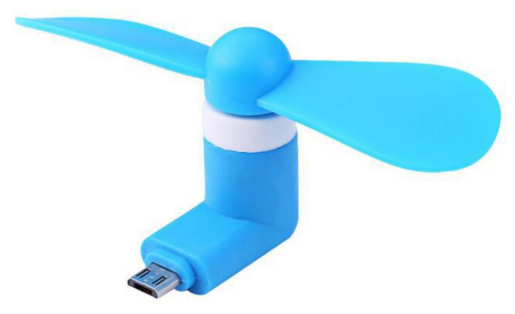

In [19]:
id = df_img.loc[53, 'image']
path_img = img_dir+f"{id}"
DisplotData.display_external_images([path_img])

In [21]:
# sift = cv2.xfeatures2d.SIFT_create()
sift = cv2.SIFT_create()

In [22]:
image = cv2.imread(path_img, 0) # convert in gray
image is None

False

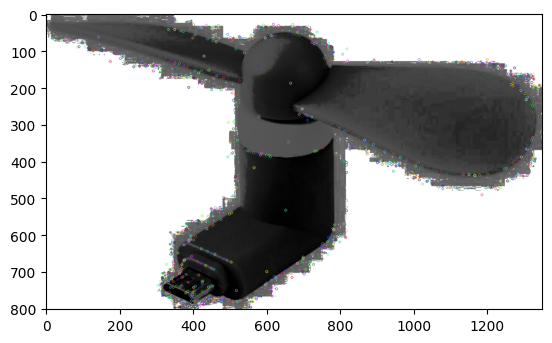

Descripteurs :  (969, 128)

[[  7.   6.   1. ...  67.   1.   1.]
 [ 14.  10.   0. ...  50.   1.   0.]
 [ 71.  31.  11. ...   1.   0.   0.]
 ...
 [ 54.  36.   0. ...   0.   3.  75.]
 [ 93.   0.   0. ...   0.   0.   1.]
 [138.  85.  10. ...   0.   0.   0.]]


In [23]:
image = cv2.equalizeHist(image)   # equalize image histogram
kp, des = sift.detectAndCompute(image, None)
img = cv2.drawKeypoints(image,kp,image)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)

# Pré-traitement des images via SIFT

## Créations des descripteurs de chaque image

In [26]:
nb_features = 500

In [27]:
sift_keypoints = []
# sift = cv2.xfeatures2d.SIFT_create(500)
# sift = cv2.xfeatures2d.SIFT_create(nb_features)
sift = cv2.SIFT_create(nb_features)

In [28]:
df_img['categs_1st'].unique()

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

In [29]:
TEST_UNITAIRE = False # A 2 classes

In [30]:
if TEST_UNITAIRE:
    df_img2 = df_img.loc[(df_img['categs_1st']=='Watches') | (df_img['categs_1st']=='Beauty and Personal Care')]
else:
    df_img2 = df_img.copy()

In [31]:
temps1 = time.time()
for image_num in df_img2.index:
    id = df_img2.loc[image_num, 'image']
    path_img = img_dir+f"{id}"
    if image_num%100 == 0 : print(image_num)
    image = cv2.imread(path_img,0) # convert in gray
    # image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    # Resize image
    image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_AREA)
    # equalize image histogram
    res = cv2.equalizeHist(image)
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)
duration1 = time.time()-temps1

0
100
200
300
400
500
600
700
800
900
1000


In [32]:
df_img2.shape

(1050, 19)

In [33]:
sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

print("Temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")


Nombre de descripteurs :  (319625, 128)
Temps de traitement SIFT descriptor :            88.75 secondes


C:\Users\a072108\AppData\Local\Temp\ipykernel_31128\1533804884.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sift_keypoints_by_img = np.asarray(sift_keypoints)


## Création des clusters de descripteurs

In [34]:
# Determination number of clusters
temps1 = time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1 = time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  565
Création de 565 clusters de descripteurs ...
temps de traitement kmeans :            19.43 secondes


## Création des features des images

In [35]:
# Creation of histograms (features)
temps1 = time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors = []

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1 = time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")


0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :            11.44 secondes


## Réductions de dimension

### Réduction de dimension PCA

In [36]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 565)
Dimensions dataset après réduction PCA :  (1050, 457)


### Réduction de dimension T-SNE

In [38]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', learning_rate='auto', random_state=18011975) # init='pca', sinon
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne['class'] = df_img2['categs_1st_num']
print(df_tsne.shape)

(1050, 3)


## Analyse visuelle : affichage T-SNE selon catégories d'images

In [39]:
list_labels = np.unique(df_img2['categs_1st_num'])
n_clusters = len(list_labels)
n_clusters

7

## Analyse mesures : similarité entre catégories et clusters

###  Création de clusters à partir du T-SNE

In [40]:
y_cat_num2 = df_img2['categs_1st_num'].values
n_cat2 = len(np.unique(y_cat_num2))
cls = cluster.KMeans(n_clusters=n_cat2, random_state=18011975)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters

In [43]:
l_cat2 = list(set(df_img2['categs_1st']))
ARI, X_tsne, labels = ARI_fct(feat_pca, y_cat_num2, n_cat2, perplexity=30, n_iter=3000)

ARI :  0.0244 time :  39.0


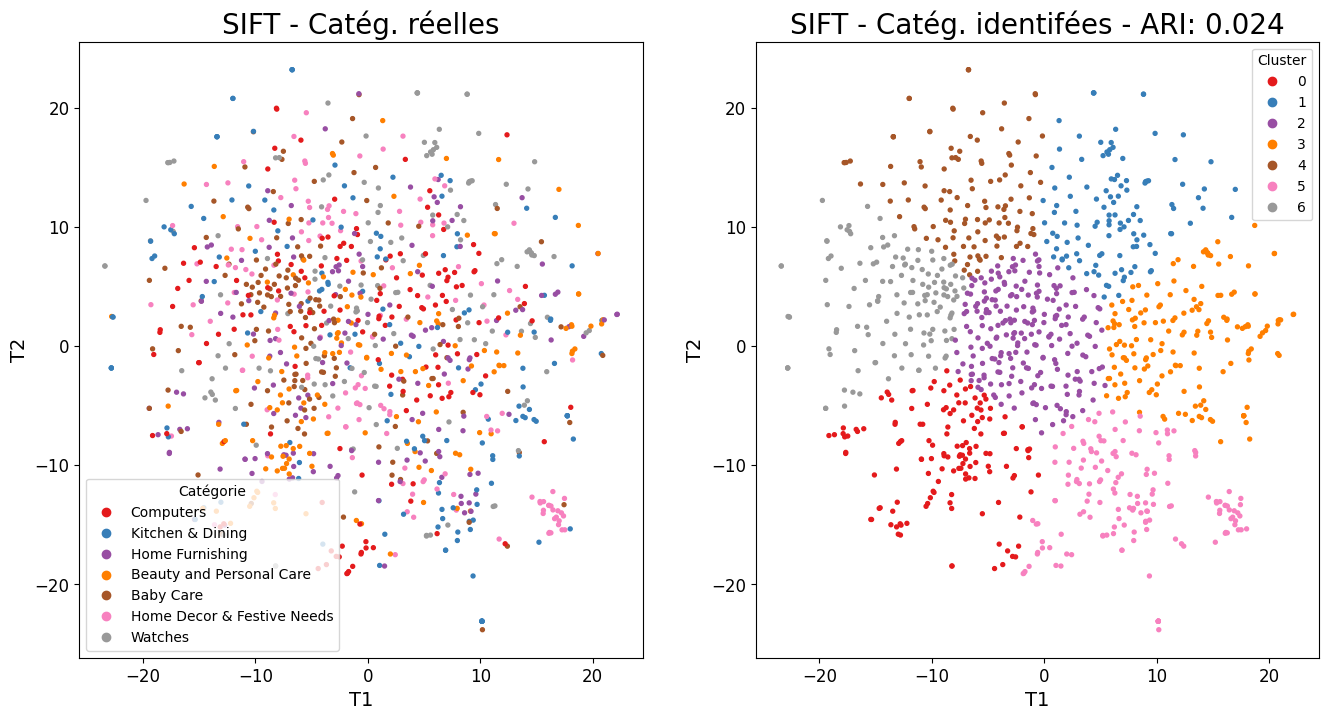

ARI : 0.0244


In [45]:
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

feature_extractor = 'SIFT'
TSNE_visu_fct(X_tsne, l_cat2, y_cat_num2, labels, ARI, title_prefix=feature_extractor)

Le résultat est sérieusement mauvais. Après rebouclage avec le mentor, ce n'est pas anormal. 

## Analyse par classe

In [46]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls.labels_))

[[ 95  11   0  11   7   8  10]
 [  2  12   4  66   4   4  23]
 [ 38  14   5  39   6  30  89]
 [  1  34   3   6 107   1  10]
 [ 16   4   3   6   5  29  57]
 [  0  16 114   0  20   5   0]
 [ 12  12   5   9   0  81  16]]

              precision    recall  f1-score   support

           0       0.58      0.67      0.62       142
           1       0.12      0.10      0.11       115
           2       0.04      0.02      0.03       221
           3       0.04      0.04      0.04       162
           4       0.03      0.04      0.04       120
           5       0.03      0.03      0.03       155
           6       0.08      0.12      0.09       135

    accuracy                           0.14      1050
   macro avg       0.13      0.15      0.14      1050
weighted avg       0.12      0.14      0.13      1050



<AxesSubplot: >

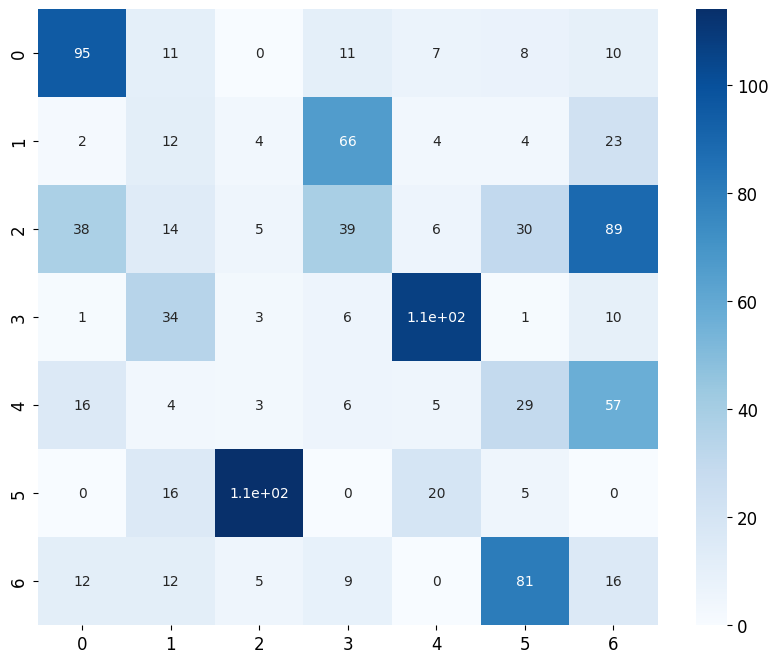

In [47]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [str(i) for i in list_labels])
plt.figure(figsize = (10,8))
sns.heatmap(df_cm, annot=True, cmap="Blues")

Les résultats sont plutôt très mauvais.

# Images - Approche CNN + Transfer Learning

In [107]:
n_class = 7

In [48]:
def read_and_prep_images(img_paths, img_height, img_width, preprocess_input):
    imgs = [load_img(img_path, target_size=(img_height, img_width)) for img_path in img_paths]
    img_array = np.array([img_to_array(img) for img in imgs])
#     img_array = [image.reshape((1, image.shape[0], image.shape[1], image.shape[2])) for image in img_array]
    return preprocess_input(img_array)

## Tests sur une image

### Oxford's VGG-16

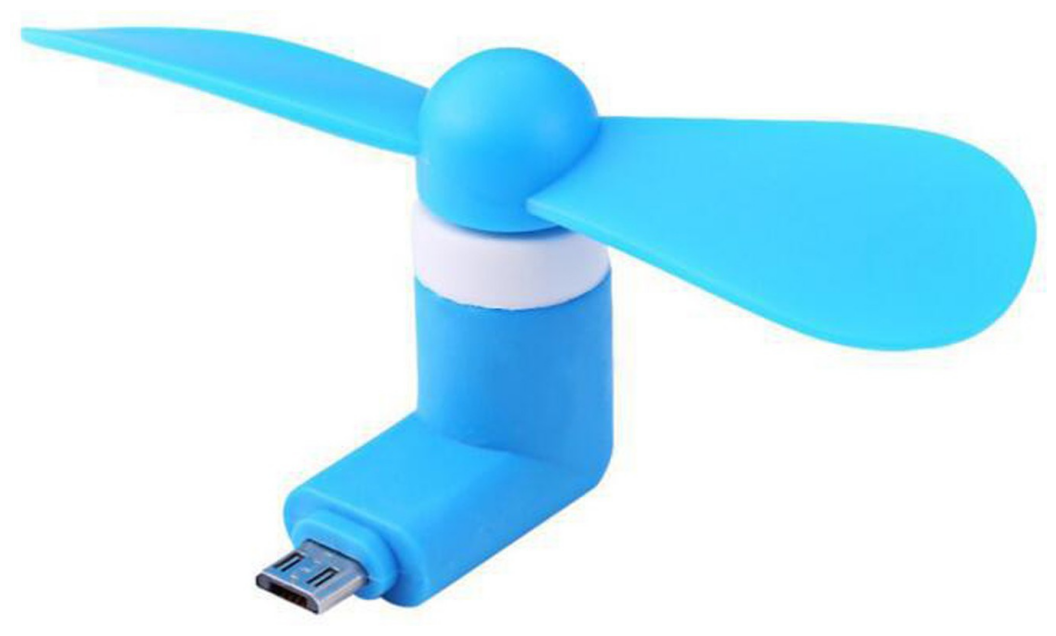

In [49]:
id = df_img.loc[53, 'image']
path_img1 = img_dir+f"{id}"
DisplotData.display_external_images([path_img1])

In [50]:
img1 = load_img(path_img1, target_size=(224, 224))  # Charger l'image
img1 = img_to_array(img1)  # Convertir en tableau numpy
img1 = img1.reshape((1, img1.shape[0], img1.shape[1], img1.shape[2]))  # Créer la collection d'images (un seul échantillon)
img1_16 = preprocess_input_VGG16(img1)  # Prétraiter l'image comme le veut VGG-16

In [51]:
path_img1

'../data/raw/images/6329ddb46087cb8c09ced95471dd9643.jpg'

In [52]:
model_16 = VGG16() # Création du modèle VGG-16 implementé par Keras
y = model_16.predict(img1_16)  # Prédir la classe de l'image (parmi les 1000 classes d'ImageNet)

# Afficher les 3 classes les plus probables
print('Top 3 :', decode_predictions_VGG16(y, top=3)[0])

35363/35363 [==============================] - 0s 2us/step
Top 3 : [('n03255030', 'dumbbell', 0.19429123), ('n04579432', 'whistle', 0.16359465), ('n03483316', 'hand_blower', 0.11570346)]


- `'dumbbell'` : haltère
- `'whistle'` : sifflet
- `'hand_blower'` : sèche-cheveux ?

<img src="dumbbell.png" />

Autre image :

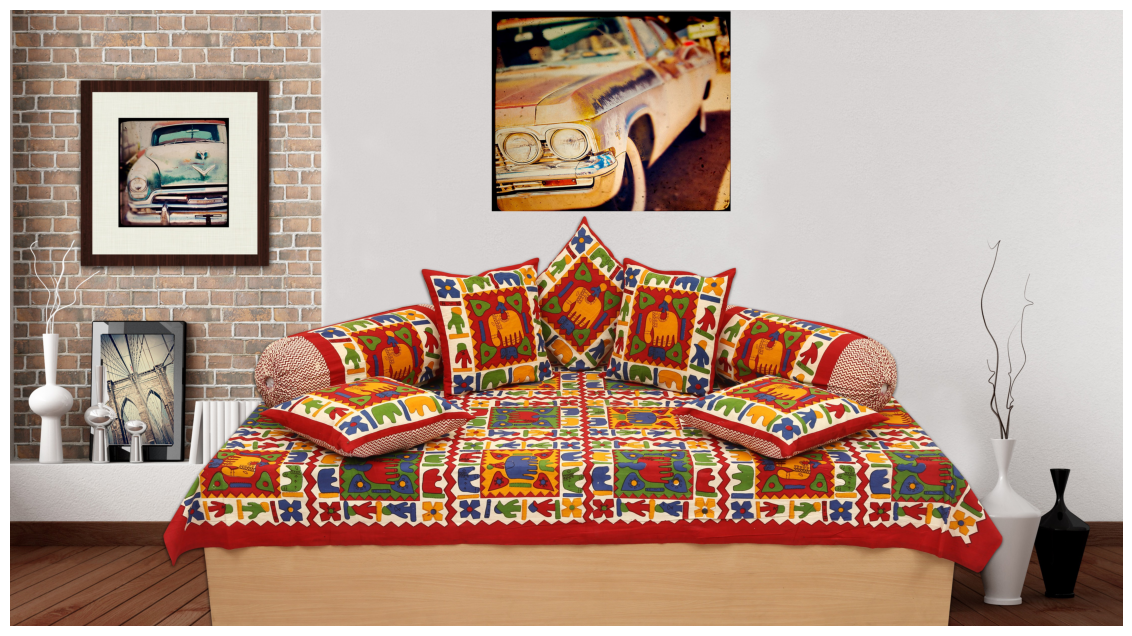

In [53]:
id = df_img.loc[78, 'image']
path_img2 = img_dir+f"{id}"
DisplotData.display_external_images([path_img2])

In [54]:
img2 = load_img(path_img2, target_size=(224, 224))  # Charger l'image
img2 = img_to_array(img2)  # Convertir en tableau numpy
img2 = img2.reshape((1, img2.shape[0], img2.shape[1], img2.shape[2]))
img2_16 = preprocess_input_VGG16(img2)  # Prétraiter l'image comme le veut VGG-16

In [55]:
y = model_16.predict(img2_16)  # Prédir la classe de l'image (parmi les 1000 classes d'ImageNet)

# Afficher les 3 classes les plus probables
print('Top 3 :', decode_predictions_VGG16(y, top=3)[0])

1/1 [==============================] - 0s 493ms/step
Top 3 : [('n04344873', 'studio_couch', 0.19602783), ('n03026506', 'Christmas_stocking', 0.15539588), ('n04429376', 'throne', 0.09412975)]


- `'studio_couch'` : canapé-studio 👍
- `'Christmas_stocking'` : collant de Noël 😆
- `'throne'` : c'est un jeu ?

### Google's InceptionV3

In [56]:
img_size = 299
img1_3 = read_and_prep_images([path_img1], img_size, img_size, preprocess_input_InV3)
img2_3 = read_and_prep_images([path_img2], img_size, img_size, preprocess_input_InV3)

In [57]:
model_3 = InceptionV3()

96112376/96112376 [==============================] - 21s 0us/step


In [58]:
y = model_3.predict(img1_3)  # Prédir la classe de l'image (parmi les 1000 classes d'ImageNet)

# Afficher les 3 classes les plus probables
print('Top 3 :', decode_predictions_InV3(y, top=3)[0])

1/1 [==============================] - 3s 3s/step
Top 3 : [('n02951585', 'can_opener', 0.20720781), ('n03255030', 'dumbbell', 0.0628163), ('n04127249', 'safety_pin', 0.030750765)]


- `can_opener` : ouvre-boîte (assez d'accord 😂)
- `dumbbell` : haltère (c'est fou ça)
- `safety_pin` : épingle à nourrice

In [59]:
y = model_3.predict(img2_3)  # Prédir la classe de l'image (parmi les 1000 classes d'ImageNet)

# Afficher les 3 classes les plus probables
print('Top 3 :', decode_predictions_InV3(y, top=3)[0])

1/1 [==============================] - 0s 264ms/step
Top 3 : [('n04033995', 'quilt', 0.6881944), ('n04344873', 'studio_couch', 0.079663716), ('n03938244', 'pillow', 0.017419597)]


- `quilt` : édredon, bien !
- `studio_couch` : aussi ! 
- `pillow` : mais oui !

### Microsoft's ResNet50

In [60]:
img_size = 224
img1_50 = read_and_prep_images([path_img1], img_size, img_size, preprocess_input_RN50)
img2_50 = read_and_prep_images([path_img2], img_size, img_size, preprocess_input_RN50)

In [61]:
model_50 = ResNet50()

102967424/102967424 [==============================] - 23s 0us/step


In [62]:
y = model_50.predict(img1_50)  # Prédir la classe de l'image (parmi les 1000 classes d'ImageNet)

# Afficher les 3 classes les plus probables
print('Top 3 :', decode_predictions_RN50(y, top=3)[0])

1/1 [==============================] - 2s 2s/step
Top 3 : [('n03532672', 'hook', 0.19143365), ('n03271574', 'electric_fan', 0.18516363), ('n03255030', 'dumbbell', 0.110617295)]


- `hook` : bizarre
- `electric_fan` : bravo !
- `dumbbell` : et ben.

<img src="hook-blue.jpg" />

In [63]:
y = model_50.predict(img2_50)  # Prédir la classe de l'image (parmi les 1000 classes d'ImageNet)

# Afficher les 3 classes les plus probables
print('Top 3 :', decode_predictions_RN50(y, top=3)[0])

1/1 [==============================] - 0s 281ms/step
Top 3 : [('n03938244', 'pillow', 0.28902853), ('n02699494', 'altar', 0.13209063), ('n04429376', 'throne', 0.09286143)]


- `pillow` : bien
- `altar` : autel, mouais
- `throne` : encore ?!

## Extraction des features

### Oxford's VGG-16

In [64]:
model = VGG16()

# remove the output layer
# model_VGG16 = Model(inputs=model.inputs, outputs=model.layers[-2].output) # Laisse 2 couches de FC !
# model_VGG16 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3)) # Trop de dim de sortie
model_VGG16 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3), pooling='avg')

58889256/58889256 [==============================] - 13s 0us/step


In [112]:
model_VGG16.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

On préprocesse les images pour qu'elles correspondent aux dimensions attendues :

In [68]:
img_paths = [os.path.join(img_dir, file) for file in df_img['image'].values]
y_cat_num = df_img['categs_1st_num'].values

On fixe la taille des images en entrée de VGG-16 à 224x224 :

In [69]:
img_size = 224
imgs = read_and_prep_images(img_paths, img_size, img_size, preprocess_input_VGG16)

C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\PIL\Image.py:3074: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


On envoie nos images en entrée du modèle :

In [70]:
features_VGG16 = model_VGG16.predict(imgs)

33/33 [==============================] - 344s 10s/step


In [73]:
l_cat = list(set(df_img['categs_1st']))
n_cat = len(np.unique(y_cat_num))
ARI, X_tsne, labels = ARI_fct(features_VGG16, y_cat_num, n_cat, perplexity=20, n_iter=3000)

ARI :  0.4299 time :  28.0


`perplexity=20` donne de meilleurs résultats.

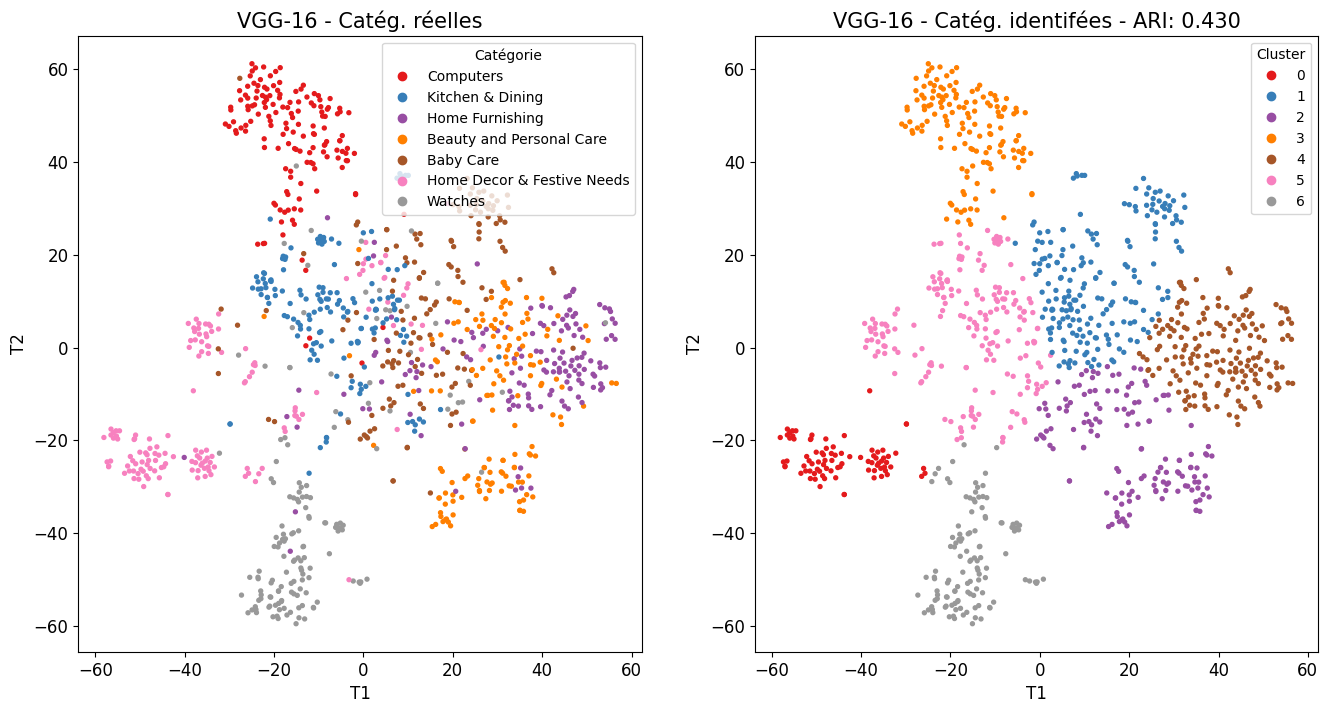

ARI : 0.4299


In [74]:
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
feature_extractor = 'VGG-16'
TSNE_visu_fct(X_tsne, l_cat, y_cat_num, labels, ARI, title_prefix=feature_extractor)

In [75]:
feat_extractor = 'VGG-16'

In [84]:
# Création des planches d'images
lc = 'label_'+feat_extractor
image_col = 'image'
df_tk[lc] = labels
create_output_images(df_tk, lc, image_col, feat_extractor, input_path=data_raw_dir, output_path=data_output_dir, verbose=1)

Création des images correspondant aux clusters...
Cluster 0 : 84 produits
Cluster 1 : 197 produits
Cluster 2 : 141 produits
Cluster 3 : 143 produits
Cluster 4 : 180 produits
Cluster 5 : 188 produits


C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\PIL\Image.py:3074: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Cluster 6 : 117 produits


### Google's InceptionV3

In [85]:
# load model
model = InceptionV3()
model_InV3 = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# summarize the model
model_InV3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 149, 149, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 149, 149, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                             

 batch_normalization_99 (BatchN  (None, 35, 35, 64)  192         ['conv2d_99[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_101 (Batch  (None, 35, 35, 64)  192         ['conv2d_101[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_104 (Batch  (None, 35, 35, 96)  288         ['conv2d_104[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_105 (Batch  (None, 35, 35, 32)  96          ['conv2d_105[0][0]']             
 Normaliza

                                                                                                  
 batch_normalization_116 (Batch  (None, 35, 35, 64)  192         ['conv2d_116[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_116 (Activation)    (None, 35, 35, 64)   0           ['batch_normalization_116[0][0]']
                                                                                                  
 conv2d_114 (Conv2D)            (None, 35, 35, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_117 (Conv2D)            (None, 35, 35, 96)   55296       ['activation_116[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 17, 17, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 17, 17, 768)  0           ['activation_120[0][0]',         
                                                                  'activation_123[0][0]',         
                                                                  'max_pooling2d_6[0][0]']        
                                                                                                  
 conv2d_128 (Conv2D)            (None, 17, 17, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_128 (Batch  (None, 17, 17, 128)  384        ['conv2d_128[0][0]']             
 Normaliza

                                                                  'activation_133[0][0]']         
                                                                                                  
 conv2d_138 (Conv2D)            (None, 17, 17, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_138 (Batch  (None, 17, 17, 160)  480        ['conv2d_138[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_138 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_138[0][0]']
                                                                                                  
 conv2d_139 (Conv2D)            (None, 17, 17, 160)  179200      ['activation_138[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 activation_148 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_148[0][0]']
                                                                                                  
 conv2d_149 (Conv2D)            (None, 17, 17, 160)  179200      ['activation_148[0][0]']         
                                                                                                  
 batch_normalization_149 (Batch  (None, 17, 17, 160)  480        ['conv2d_149[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_149 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_149[0][0]']
          

                                                                                                  
 batch_normalization_159 (Batch  (None, 17, 17, 192)  576        ['conv2d_159[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_159 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_159[0][0]']
                                                                                                  
 conv2d_155 (Conv2D)            (None, 17, 17, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_160 (Conv2D)            (None, 17, 17, 192)  258048      ['activation_159[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_164 (Conv2D)            (None, 17, 17, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_168 (Conv2D)            (None, 17, 17, 192)  258048      ['activation_167[0][0]']         
                                                                                                  
 batch_normalization_164 (Batch  (None, 17, 17, 192)  576        ['conv2d_164[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_168 (Batch  (None, 17, 17, 192)  576        ['conv2d_168[0][0]']             
 Normalization)                                                                                   
          

 batch_normalization_170 (Batch  (None, 8, 8, 320)   960         ['conv2d_170[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_172 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_172[0][0]']
                                                                                                  
 activation_173 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_173[0][0]']
                                                                                                  
 activation_176 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_176[0][0]']
                                                                                                  
 activation_177 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_177[0][0]']
          

                                                                                                  
 activation_185 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_185[0][0]']
                                                                                                  
 activation_186 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_186[0][0]']
                                                                                                  
 batch_normalization_187 (Batch  (None, 8, 8, 192)   576         ['conv2d_187[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_179 (Activation)    (None, 8, 8, 320)    0           ['batch_normalization_179[0][0]']
                                                                                                  
 mixed9_1 

Mazette.

On fixe la taille des images en entrée de InceptionV3 à 299x299 :

In [86]:
img_size = 299
imgs = read_and_prep_images(img_paths, img_size, img_size, preprocess_input_InV3)

On envoie nos images en entrée du modèle :

In [87]:
features_InV3 = model_InV3.predict(imgs)

33/33 [==============================] - 162s 5s/step


In [88]:
n_cat = len(np.unique(y_cat_num))
ARI, X_tsne, labels = ARI_fct(features_InV3, y_cat_num, n_cat, perplexity=25, n_iter=2000)

ARI :  0.5608 time :  26.0


`perplexity=25`, `n_iter=2000` donnent de meilleurs résultats.

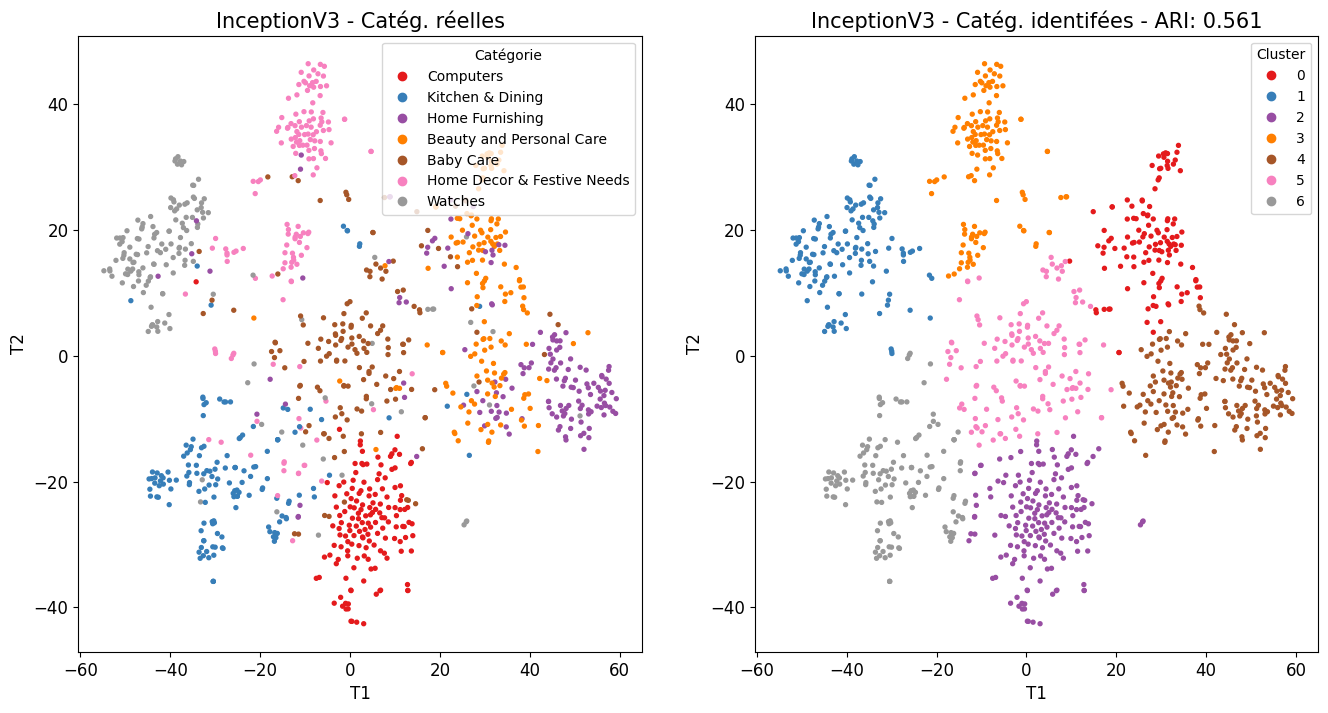

ARI : 0.5608


In [89]:
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
feature_extractor = 'InceptionV3'
TSNE_visu_fct(X_tsne, l_cat, y_cat_num, labels, ARI, title_prefix=feature_extractor)

In [90]:
feature_extractor = 'InceptionV3'

In [91]:
# Création des planches d'images
lc = 'label_'+feature_extractor
image_col = 'image'
df_tk[lc] = labels
create_output_images(df_tk, lc, image_col, feat_extractor, input_path=data_raw_dir, output_path=data_output_dir, verbose=1)

Création des images correspondant aux clusters...
Cluster 0 : 122 produits
Cluster 1 : 148 produits


C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\PIL\Image.py:3074: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Cluster 2 : 180 produits
Cluster 3 : 128 produits
Cluster 4 : 179 produits
Cluster 5 : 147 produits
Cluster 6 : 146 produits


### Microsoft's ResNet50

In [92]:
# load model
model = ResNet50()
model_RN50 = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# summarize the model
model_RN50.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

On fixe la taille des images en entrée de ResNet50 à 224x224 :

In [93]:
img_size = 224
imgs = read_and_prep_images(img_paths, img_size, img_size, preprocess_input_RN50)

On envoie nos images en entrée du modèle :

In [94]:
features_RN50 = model_RN50.predict(imgs)

33/33 [==============================] - 139s 4s/step


In [95]:
n_cat = len(np.unique(y_cat_num))
ARI, X_tsne, labels = ARI_fct(features_RN50, y_cat_num, n_cat, perplexity=25, n_iter=2000)

ARI :  0.5372 time :  20.0


`perplexity=25`, `n_iter=2000` donnent de meilleurs résultats.

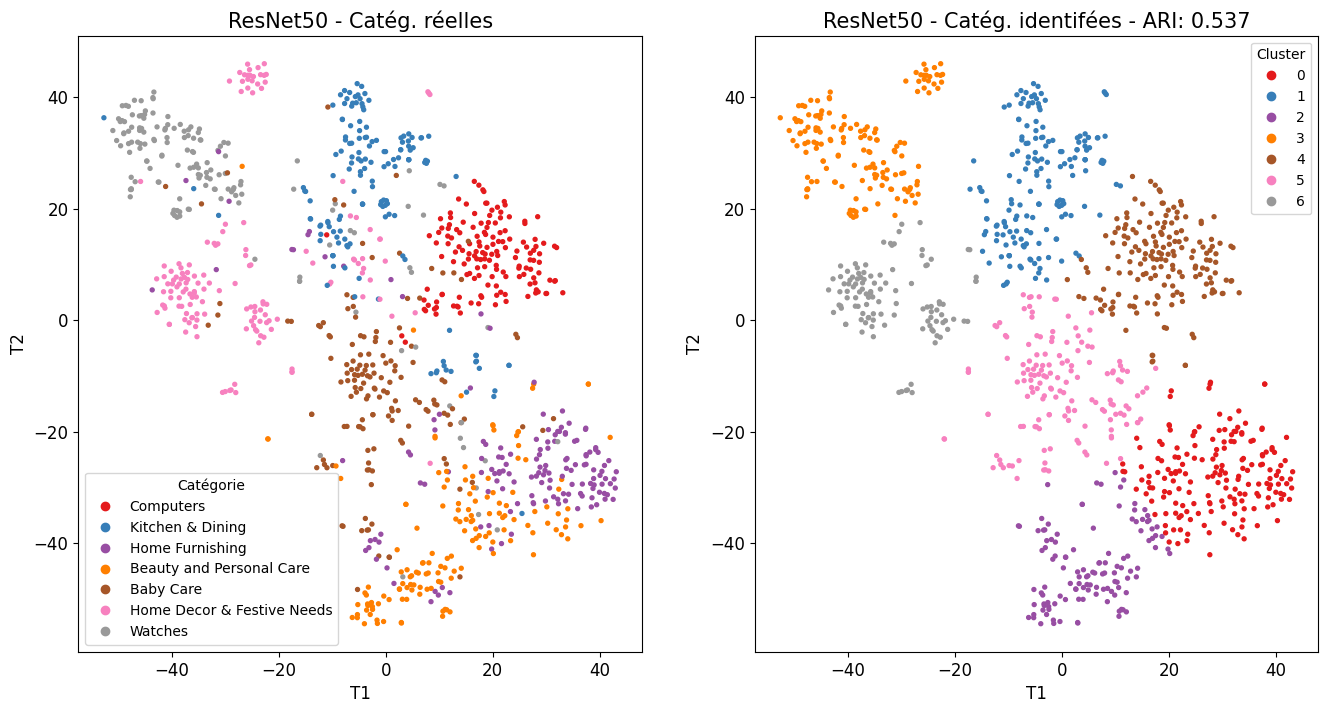

ARI : 0.5372


In [96]:
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
feature_extractor = 'ResNet50'
TSNE_visu_fct(X_tsne, l_cat, y_cat_num, labels, ARI, title_prefix=feature_extractor)

In [97]:
feature_extractor = 'ResNet50'

In [98]:
# Création des planches d'images
lc = 'label_'+feature_extractor
image_col = 'image'
df_tk[lc] = labels
create_output_images(df_tk, lc, image_col, feat_extractor, input_path=data_raw_dir, output_path=data_output_dir, verbose=1)

Création des images correspondant aux clusters...
Cluster 0 : 179 produits
Cluster 1 : 169 produits


C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\PIL\Image.py:3074: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Cluster 2 : 120 produits
Cluster 3 : 150 produits
Cluster 4 : 172 produits
Cluster 5 : 149 produits
Cluster 6 : 111 produits


In [99]:
%store features_VGG16
%store features_InV3
%store features_RN50

Stored 'features_VGG16' (ndarray)
Stored 'features_InV3' (ndarray)
Stored 'features_RN50' (ndarray)


## Transfer Learning

In [100]:
REBUILD_MODELS = False

On remplace maintenant les couches Fully Connected pour classifier notre jeu de données de manière supervisée.

In [101]:
epochs = 100 # 500
batch_size = 32

### Oxford's VGG-16

In [102]:
img_size = 224
imgs = read_and_prep_images(img_paths, img_size, img_size, preprocess_input_VGG16)

In [103]:
X_enc = imgs
y_enc = df_img['categs_1st_num']

In [104]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_enc, y_enc, test_size=0.2, random_state=18011975)

In [105]:
y_train_enc = tf.keras.utils.to_categorical(y_train)
y_test_enc = tf.keras.utils.to_categorical(y_test)

#### Création du modèle

In [ ]:
# Instanciation du modèle public 
# model_VGG16 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3), pooling='avg')
# model_VGG16 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
# model_VGG16 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3), classes=n_class)
# model_VGG16 = VGG16(weights="imagenet", input_shape=(224, 224, 3))
model = VGG16(weights="imagenet", input_shape=(224, 224, 3))
model_VGG16 = Model(inputs=model.inputs, outputs=model.layers[-2].output)
model_VGG16.summary()

# Récupération la sortie de ce réseau
x = model_VGG16.output

predictions = Dense(n_class, activation='softmax')(x)

# Ajout de la nouvelle couche
my_model_VGG16 = Model(inputs=model_VGG16.input, outputs=predictions)

# Fine tuning : on n'entraîne que la dernière couche :
for layer in my_model_VGG16.layers[:-1]:
    layer.trainable = False
my_model_VGG16.layers[-1].trainable = True
my_model_VGG16.summary()

# Compilation du modèle 
my_model_VGG16.compile(loss="categorical_crossentropy", 
                       optimizer=optimizers.SGD(learning_rate=0.0001, momentum=0.9),
                       metrics=["accuracy"])
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=8,
                               min_delta=0.001,
                               mode='max')

In [113]:
# Entraîner sur les données d'entraînement
model_info_VGG16 = my_model_VGG16.fit(X_train, y_train_enc,
                                      epochs=epochs,
                                      batch_size=batch_size,
                                      validation_split=0.2,
                                      callbacks=[early_stopping],
                                      verbose=2)

Epoch 1/100
21/21 - 311s - loss: 0.8798 - accuracy: 0.7232 - val_loss: 1.0726 - val_accuracy: 0.6726 - 311s/epoch - 15s/step
Epoch 2/100
21/21 - 296s - loss: 0.6738 - accuracy: 0.7827 - val_loss: 0.9816 - val_accuracy: 0.7143 - 296s/epoch - 14s/step
Epoch 3/100
21/21 - 322s - loss: 0.5699 - accuracy: 0.8155 - val_loss: 0.9306 - val_accuracy: 0.7321 - 322s/epoch - 15s/step
Epoch 4/100
21/21 - 279s - loss: 0.5057 - accuracy: 0.8438 - val_loss: 0.9024 - val_accuracy: 0.7440 - 279s/epoch - 13s/step
Epoch 5/100
21/21 - 114s - loss: 0.4502 - accuracy: 0.8735 - val_loss: 0.8771 - val_accuracy: 0.7560 - 114s/epoch - 5s/step
Epoch 6/100
21/21 - 117s - loss: 0.4135 - accuracy: 0.8810 - val_loss: 0.8717 - val_accuracy: 0.7500 - 117s/epoch - 6s/step
Epoch 7/100
21/21 - 118s - loss: 0.3802 - accuracy: 0.8943 - val_loss: 0.8532 - val_accuracy: 0.7500 - 118s/epoch - 6s/step
Epoch 8/100
21/21 - 115s - loss: 0.3519 - accuracy: 0.9077 - val_loss: 0.8517 - val_accuracy: 0.7560 - 115s/epoch - 5s/step
Epoc

#### Evaluation du modèle

In [114]:
_, train_acc = my_model_VGG16.evaluate(X_train, y_train_enc, verbose=0)
_, test_acc = my_model_VGG16.evaluate(X_test, y_test_enc, verbose=0)
print(f"Train : {train_acc:.4f}, Test : {test_acc:.4f}")

Train : 0.9452, Test : 0.8238


#### Sauvegarde du modèle 

In [116]:
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

In [126]:
# Serialize model to JSON
fname = f"my_model_VGG16_{train_acc:.2f}_{test_acc:.2f}_{timestamp}"
my_model_VGG16_json = my_model_VGG16.to_json()
with open(fname+".json", "w") as json_file:
    json_file.write(my_model_VGG16_json)
    
# Serialize weights to HDF5
my_model_VGG16.save_weights(fname+".h5")

In [118]:
%store my_model_VGG16

INFO:tensorflow:Assets written to: ram://a3554530-b143-4ce4-bab7-2f5a129f21f4/assets


INFO:tensorflow:Assets written to: ram://a3554530-b143-4ce4-bab7-2f5a129f21f4/assets


Stored 'my_model_VGG16' (Functional)


### Google's InceptionV3

In [119]:
img_size = 299
imgs_InV3 = read_and_prep_images(img_paths, img_size, img_size, preprocess_input_InV3)

C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\PIL\Image.py:3074: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [120]:
X_enc = imgs_InV3
y_enc = df_img['categs_1st_num']

In [121]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_enc, y_enc, test_size=0.2, random_state=18011975)

In [122]:
y_train_enc = tf.keras.utils.to_categorical(y_train)
y_test_enc = tf.keras.utils.to_categorical(y_test)

#### Création du modèle

In [123]:
# Instanciation du modèle public 
model = InceptionV3()
model_InV3 = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# Récupération la sortie de ce réseau
x = model_InV3.output
predictions = Dense(n_class, activation='softmax')(x)

# Ajout de la nouvelle couche
my_model_InV3 = Model(inputs=model_InV3.input, outputs=predictions)

# Fine tuning : on n'entraîne que la dernière couche :
for layer in my_model_InV3.layers[:-1]:
    layer.trainable = False
my_model_InV3.layers[-1].trainable = True
my_model_InV3.summary()

# Compilation du modèle 
my_model_InV3.compile(loss="categorical_crossentropy", 
                      optimizer=optimizers.SGD(learning_rate=0.0001, momentum=0.9),
                      metrics=["accuracy"])
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=2,
                               min_delta=0.001,
                               mode='max')

# Entraîner sur les données d'entraînement
model_info_InV3 = my_model_InV3.fit(X_train, y_train_enc,
                                    epochs=epochs,
                                    batch_size=batch_size,
                                    validation_split=0.2,
                                    callbacks=[early_stopping],
                                    verbose=2)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 149, 149, 32  864         ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_188 (Batch  (None, 149, 149, 32  96         ['conv2d_188[0][0]']             
 Normalization)                 )                                                           

 batch_normalization_193 (Batch  (None, 35, 35, 64)  192         ['conv2d_193[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_195 (Batch  (None, 35, 35, 64)  192         ['conv2d_195[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_198 (Batch  (None, 35, 35, 96)  288         ['conv2d_198[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_199 (Batch  (None, 35, 35, 32)  96          ['conv2d_199[0][0]']             
 Normaliza

                                                                                                  
 batch_normalization_210 (Batch  (None, 35, 35, 64)  192         ['conv2d_210[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_210 (Activation)    (None, 35, 35, 64)   0           ['batch_normalization_210[0][0]']
                                                                                                  
 conv2d_208 (Conv2D)            (None, 35, 35, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_211 (Conv2D)            (None, 35, 35, 96)   55296       ['activation_210[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_10 (MaxPooling2D  (None, 17, 17, 288)  0          ['mixed2[0][0]']                 
 )                                                                                                
                                                                                                  
 mixed3 (Concatenate)           (None, 17, 17, 768)  0           ['activation_214[0][0]',         
                                                                  'activation_217[0][0]',         
                                                                  'max_pooling2d_10[0][0]']       
                                                                                                  
 conv2d_222 (Conv2D)            (None, 17, 17, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_nor

                                                                  'activation_226[0][0]',         
                                                                  'activation_227[0][0]']         
                                                                                                  
 conv2d_232 (Conv2D)            (None, 17, 17, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_232 (Batch  (None, 17, 17, 160)  480        ['conv2d_232[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_232 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_232[0][0]']
                                                                                                  
 conv2d_23

 batch_normalization_242 (Batch  (None, 17, 17, 160)  480        ['conv2d_242[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_242 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_242[0][0]']
                                                                                                  
 conv2d_243 (Conv2D)            (None, 17, 17, 160)  179200      ['activation_242[0][0]']         
                                                                                                  
 batch_normalization_243 (Batch  (None, 17, 17, 160)  480        ['conv2d_243[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 conv2d_253 (Conv2D)            (None, 17, 17, 192)  258048      ['activation_252[0][0]']         
                                                                                                  
 batch_normalization_253 (Batch  (None, 17, 17, 192)  576        ['conv2d_253[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_253 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_253[0][0]']
                                                                                                  
 conv2d_249 (Conv2D)            (None, 17, 17, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_254 (Conv2D)            (None, 17, 17, 192)  258048      ['activation_253[0][0]']         
          

 activation_261 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_261[0][0]']
                                                                                                  
 conv2d_258 (Conv2D)            (None, 17, 17, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_262 (Conv2D)            (None, 17, 17, 192)  258048      ['activation_261[0][0]']         
                                                                                                  
 batch_normalization_258 (Batch  (None, 17, 17, 192)  576        ['conv2d_258[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_262 (Batch  (None, 17, 17, 192)  576        ['conv2d_262[0][0]']             
 Normaliza

 conv2d_272 (Conv2D)            (None, 8, 8, 192)    245760      ['average_pooling2d_25[0][0]']   
                                                                                                  
 batch_normalization_264 (Batch  (None, 8, 8, 320)   960         ['conv2d_264[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_266 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_266[0][0]']
                                                                                                  
 activation_267 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_267[0][0]']
                                                                                                  
 activation_270 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_270[0][0]']
          

                                                                                                  
 activation_276 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_276[0][0]']
                                                                                                  
 activation_279 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_279[0][0]']
                                                                                                  
 activation_280 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_280[0][0]']
                                                                                                  
 batch_normalization_281 (Batch  (None, 8, 8, 192)   576         ['conv2d_281[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

#### Evaluation du modèle

In [124]:
_, train_acc = my_model_InV3.evaluate(X_train, y_train_enc, verbose=0)
_, test_acc = my_model_InV3.evaluate(X_test, y_test_enc, verbose=0)
print(f"Train : {train_acc:.4f}, Test : {test_acc:.4f}")

Train : 0.7536, Test : 0.7381


#### Sauvegarde du modèle 

In [125]:
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

In [127]:
# Serialize model to JSON
fname = f"my_model_InV3_{train_acc:.2f}_{test_acc:.2f}_{timestamp}"
my_model_InV3_json = my_model_InV3.to_json()
with open(fname+".json", "w") as json_file:
    json_file.write(my_model_InV3_json)
    
# Serialize weights to HDF5
my_model_InV3.save_weights(fname+".h5")

In [128]:
%store my_model_InV3

INFO:tensorflow:Assets written to: ram://09770524-0144-48c7-bc67-57ca517eb915/assets


INFO:tensorflow:Assets written to: ram://09770524-0144-48c7-bc67-57ca517eb915/assets


Stored 'my_model_InV3' (Functional)


### Microsoft's ResNet50

In [129]:
img_size = 224
imgs_RN50 = read_and_prep_images(img_paths, img_size, img_size, preprocess_input_RN50)

C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\PIL\Image.py:3074: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [130]:
X_enc = imgs_RN50
y_enc = df_img['categs_1st_num']

In [131]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_enc, y_enc, test_size=0.2, random_state=18011975)

In [132]:
y_train_enc = tf.keras.utils.to_categorical(y_train)
y_test_enc = tf.keras.utils.to_categorical(y_test)

#### Création du modèle

In [135]:
# Instanciation du modèle public
model = ResNet50()
model_RN50 = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# Récupération la sortie de ce réseau
x = model_RN50.output
predictions = Dense(n_class, activation='softmax')(x)

# Ajout de la nouvelle couche
my_model_RN50 = Model(inputs=model_RN50.input, outputs=predictions)

# Fine tuning : on n'entraîne que la dernière couche :
for layer in my_model_RN50.layers[:-1]:
    layer.trainable = False
my_model_RN50.layers[-1].trainable = True
my_model_RN50.summary()

# Compilation du modèle
my_model_RN50.compile(loss="categorical_crossentropy",
                      optimizer=optimizers.SGD(
                          learning_rate=0.0001, momentum=0.9),
                      metrics=["accuracy"])

early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=2,
                               min_delta=0.001,
                               mode='max')

# Entraîner sur les données d'entraînement
model_info_RN50 = my_model_RN50.fit(X_train, y_train_enc,
                                    epochs=epochs,
                                    batch_size=batch_size,
                                    validation_split=0.2,
                                    callbacks=[early_stopping],
                                    verbose=2)

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_13[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

Epoch 17/100
21/21 - 51s - loss: 0.5146 - accuracy: 0.8571 - val_loss: 0.7162 - val_accuracy: 0.7679 - 51s/epoch - 2s/step
Epoch 18/100
21/21 - 52s - loss: 0.4968 - accuracy: 0.8586 - val_loss: 0.7056 - val_accuracy: 0.7679 - 52s/epoch - 2s/step


#### Evaluation du modèle

In [136]:
_, train_acc = my_model_RN50.evaluate(X_train, y_train_enc, verbose=0)
_, test_acc = my_model_RN50.evaluate(X_test, y_test_enc, verbose=0)
print(f"Train : {train_acc:.4f}, Test : {test_acc:.4f}")

Train : 0.8393, Test : 0.7667


#### Sauvegarde du modèle 

In [137]:
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

In [139]:
# Serialize model to JSON
fname = f"my_model_RN50_{train_acc:.2f}_{test_acc:.2f}_{timestamp}"
my_model_RN50_json = my_model_RN50.to_json()
with open(fname+".json", "w") as json_file:
    json_file.write(my_model_RN50_json)
    
# Serialize weights to HDF5
my_model_RN50.save_weights(fname+".h5")

In [140]:
%store my_model_RN50

INFO:tensorflow:Assets written to: ram://624c8a2e-df43-4080-a602-f0bfb99b8880/assets


INFO:tensorflow:Assets written to: ram://624c8a2e-df43-4080-a602-f0bfb99b8880/assets


Stored 'my_model_RN50' (Functional)


# Vision Transformers (ViT)

In [141]:
model_name = "google/vit-base-patch16-224-in21k"
prep = transformers.AutoFeatureExtractor.from_pretrained(model_name)
vit = transformers.TFAutoModel.from_pretrained(model_name)

C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\huggingface_hub\file_download.py:129: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\a072108\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [142]:
X_enc = imgs
y_enc = df_img['categs_1st_num']

In [143]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_enc, y_enc, test_size=0.2, random_state=18011975)

In [144]:
# Preprocess 
X_train_vit = np.array([prep(img)["pixel_values"][0] for img in X_train])
X_test_vit = np.array([prep(img)["pixel_values"][0] for img in X_test])

print(X_train_vit[0].shape)

(3, 224, 224)


In [145]:
y_train_enc = tf.keras.utils.to_categorical(y_train)
y_test_enc = tf.keras.utils.to_categorical(y_test)

In [146]:
# Model
x_in = layers.Input(name="x_in", shape=(3,224,224))
vit_out = vit(x_in)[0][:,0,:]
y_out = layers.Dense(name="y_out", units=n_class, 
                     activation="softmax")(vit_out)

my_model_ViT = models.Model(inputs=x_in, outputs=y_out, name="ViT")
my_model_ViT.compile(loss="sparse_categorical_crossentropy", 
                     optimizer="adam", metrics=["accuracy"])
my_model_ViT.summary()

Model: "ViT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x_in (InputLayer)           [(None, 3, 224, 224)]     0         
                                                                 
 tf_vi_t_model (TFViTModel)  TFBaseModelOutputWithPoo  86389248  
                             ling(last_hidden_state=(            
                             None, 197, 768),                    
                              pooler_output=(None, 76            
                             8),                                 
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem (S  (None, 768)              0         
 licingOpLambda)                                                 
                                                               

In [147]:
model_info_ViT = my_model_ViT.fit(X_train_vit, y_train,
                                  epochs=epochs,
                                  batch_size=batch_size,
                                  validation_split=0.2,
                                  callbacks=[early_stopping],
                                  verbose=2)

Epoch 1/100


C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


21/21 - 712s - loss: 1.9614 - accuracy: 0.1414 - val_loss: 1.9924 - val_accuracy: 0.1131 - 712s/epoch - 34s/step
Epoch 2/100
21/21 - 671s - loss: 1.9476 - accuracy: 0.1518 - val_loss: 1.9456 - val_accuracy: 0.1429 - 671s/epoch - 32s/step
Epoch 3/100
21/21 - 671s - loss: 1.9260 - accuracy: 0.2381 - val_loss: 1.9451 - val_accuracy: 0.1607 - 671s/epoch - 32s/step
Epoch 4/100
21/21 - 669s - loss: 1.9494 - accuracy: 0.1607 - val_loss: 1.9680 - val_accuracy: 0.2202 - 669s/epoch - 32s/step
Epoch 5/100
21/21 - 674s - loss: 1.9257 - accuracy: 0.2113 - val_loss: 1.9339 - val_accuracy: 0.1786 - 674s/epoch - 32s/step
Epoch 6/100
21/21 - 679s - loss: 1.8710 - accuracy: 0.2500 - val_loss: 1.8685 - val_accuracy: 0.2679 - 679s/epoch - 32s/step
Epoch 7/100
21/21 - 669s - loss: 1.8648 - accuracy: 0.2664 - val_loss: 1.8515 - val_accuracy: 0.2560 - 669s/epoch - 32s/step
Epoch 8/100
21/21 - 669s - loss: 1.7952 - accuracy: 0.2887 - val_loss: 1.8245 - val_accuracy: 0.2381 - 669s/epoch - 32s/step


Le `early_stopping` arrête l'entraînement beaucoup trop tôt.

#### Evaluation du modèle

In [148]:
_, train_acc = my_model_ViT.evaluate(X_train_vit, y_train, verbose=0)
_, test_acc = my_model_ViT.evaluate(X_test_vit, y_test, verbose=0)
print(f"Train : {train_acc:.4f}, Test : {test_acc:.4f}")

Train : 0.2833, Test : 0.2095


Autre tentative :

In [149]:
features_ViT = vit.predict(imgs)

ValueError: in user code:

    File "C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\a072108\AppData\Local\Temp\__autograph_generated_filen_3c61vn.py", line 36, in tf__run_call_with_unpacked_inputs
        retval_ = ag__.converted_call(ag__.ld(func), (ag__.ld(self),), dict(**ag__.ld(unpacked_inputs)), fscope)
    File "C:\Users\a072108\AppData\Local\Temp\__autograph_generated_filendew3zr4.py", line 10, in tf__call
        outputs = ag__.converted_call(ag__.ld(self).vit, (), dict(pixel_values=ag__.ld(pixel_values), head_mask=ag__.ld(head_mask), output_attentions=ag__.ld(output_attentions), output_hidden_states=ag__.ld(output_hidden_states), interpolate_pos_encoding=ag__.ld(interpolate_pos_encoding), return_dict=ag__.ld(return_dict), training=ag__.ld(training)), fscope)
    File "C:\Users\a072108\AppData\Local\Temp\__autograph_generated_filen_3c61vn.py", line 36, in tf__run_call_with_unpacked_inputs
        retval_ = ag__.converted_call(ag__.ld(func), (ag__.ld(self),), dict(**ag__.ld(unpacked_inputs)), fscope)
    File "C:\Users\a072108\AppData\Local\Temp\__autograph_generated_fileof1eeh6q.py", line 23, in tf__call
        embedding_output = ag__.converted_call(ag__.ld(self).embeddings, (), dict(pixel_values=ag__.ld(pixel_values), interpolate_pos_encoding=ag__.ld(interpolate_pos_encoding), training=ag__.ld(training)), fscope)
    File "C:\Users\a072108\AppData\Local\Temp\__autograph_generated_file3x28dlgm.py", line 11, in tf__call
        embeddings = ag__.converted_call(ag__.ld(self).patch_embeddings, (ag__.ld(pixel_values),), dict(interpolate_pos_encoding=ag__.ld(interpolate_pos_encoding), training=ag__.ld(training)), fscope)
    File "C:\Users\a072108\AppData\Local\Temp\__autograph_generated_filefxv6kzpu.py", line 62, in tf__call
        projection = ag__.converted_call(ag__.ld(self).projection, (ag__.ld(pixel_values),), None, fscope)

    ValueError: Exception encountered when calling layer "tf_vi_t_model" "                 f"(type TFViTModel).
    
    in user code:
    
        File "C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\transformers\modeling_tf_utils.py", line 686, in run_call_with_unpacked_inputs  *
            return func(self, **unpacked_inputs)
        File "C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\transformers\models\vit\modeling_tf_vit.py", line 689, in call  *
            outputs = self.vit(
        File "C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "C:\Users\a072108\AppData\Local\Temp\__autograph_generated_filen_3c61vn.py", line 36, in tf__run_call_with_unpacked_inputs
            retval_ = ag__.converted_call(ag__.ld(func), (ag__.ld(self),), dict(**ag__.ld(unpacked_inputs)), fscope)
        File "C:\Users\a072108\AppData\Local\Temp\__autograph_generated_fileof1eeh6q.py", line 23, in tf__call
            embedding_output = ag__.converted_call(ag__.ld(self).embeddings, (), dict(pixel_values=ag__.ld(pixel_values), interpolate_pos_encoding=ag__.ld(interpolate_pos_encoding), training=ag__.ld(training)), fscope)
        File "C:\Users\a072108\AppData\Local\Temp\__autograph_generated_file3x28dlgm.py", line 11, in tf__call
            embeddings = ag__.converted_call(ag__.ld(self).patch_embeddings, (ag__.ld(pixel_values),), dict(interpolate_pos_encoding=ag__.ld(interpolate_pos_encoding), training=ag__.ld(training)), fscope)
        File "C:\Users\a072108\AppData\Local\Temp\__autograph_generated_filefxv6kzpu.py", line 62, in tf__call
            projection = ag__.converted_call(ag__.ld(self).projection, (ag__.ld(pixel_values),), None, fscope)
    
        ValueError: Exception encountered when calling layer "vit" "                 f"(type TFViTMainLayer).
        
        in user code:
        
            File "C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\transformers\modeling_tf_utils.py", line 686, in run_call_with_unpacked_inputs  *
                return func(self, **unpacked_inputs)
            File "C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\transformers\models\vit\modeling_tf_vit.py", line 503, in call  *
                embedding_output = self.embeddings(
            File "C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler  **
                raise e.with_traceback(filtered_tb) from None
            File "C:\Users\a072108\AppData\Local\Temp\__autograph_generated_file3x28dlgm.py", line 11, in tf__call
                embeddings = ag__.converted_call(ag__.ld(self).patch_embeddings, (ag__.ld(pixel_values),), dict(interpolate_pos_encoding=ag__.ld(interpolate_pos_encoding), training=ag__.ld(training)), fscope)
            File "C:\Users\a072108\AppData\Local\Temp\__autograph_generated_filefxv6kzpu.py", line 62, in tf__call
                projection = ag__.converted_call(ag__.ld(self).projection, (ag__.ld(pixel_values),), None, fscope)
        
            ValueError: Exception encountered when calling layer "embeddings" "                 f"(type TFViTEmbeddings).
            
            in user code:
            
                File "C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\transformers\models\vit\modeling_tf_vit.py", line 123, in call  *
                    embeddings = self.patch_embeddings(
                File "C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler  **
                    raise e.with_traceback(filtered_tb) from None
                File "C:\Users\a072108\AppData\Local\Temp\__autograph_generated_filefxv6kzpu.py", line 62, in tf__call
                    projection = ag__.converted_call(ag__.ld(self).projection, (ag__.ld(pixel_values),), None, fscope)
            
                ValueError: Exception encountered when calling layer "patch_embeddings" "                 f"(type TFViTPatchEmbeddings).
                
                in user code:
                
                    File "C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\transformers\models\vit\modeling_tf_vit.py", line 198, in call  *
                        projection = self.projection(pixel_values)
                    File "C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler  **
                        raise e.with_traceback(filtered_tb) from None
                    File "C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\keras\engine\input_spec.py", line 277, in assert_input_compatibility
                        raise ValueError(
                
                    ValueError: Input 0 of layer "projection" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (None, 224, 3, 224)
                
                
                Call arguments received by layer "patch_embeddings" "                 f"(type TFViTPatchEmbeddings):
                  • pixel_values=tf.Tensor(shape=(None, 224, 224, 3), dtype=float32)
                  • interpolate_pos_encoding=None
                  • training=False
            
            
            Call arguments received by layer "embeddings" "                 f"(type TFViTEmbeddings):
              • pixel_values=tf.Tensor(shape=(None, 224, 224, 3), dtype=float32)
              • interpolate_pos_encoding=None
              • training=False
        
        
        Call arguments received by layer "vit" "                 f"(type TFViTMainLayer):
          • self=tf.Tensor(shape=(None, 224, 224, 3), dtype=float32)
          • pixel_values=None
          • head_mask=None
          • output_attentions=False
          • output_hidden_states=False
          • interpolate_pos_encoding=None
          • return_dict=True
          • training=False
    
    
    Call arguments received by layer "tf_vi_t_model" "                 f"(type TFViTModel):
      • self=tf.Tensor(shape=(None, 224, 224, 3), dtype=float32)
      • pixel_values=None
      • head_mask=None
      • output_attentions=None
      • output_hidden_states=None
      • interpolate_pos_encoding=None
      • return_dict=None
      • training=False


In [ ]:
n_cat = len(np.unique(y_cat_num))
ARI, X_tsne, labels = ARI_fct(features_ViT, y_cat_num, n_cat, perplexity=20, n_iter=3000)

#### Sauvegarde du modèle 

In [ ]:
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

In [139]:
# Serialize model to JSON
fname = f"my_model_ViT_{train_acc:.2f}_{test_acc:.2f}_{timestamp}"
my_model_ViT_json = my_model_ViT.to_json()
with open(fname+".json", "w") as json_file:
    json_file.write(my_model_ViT_json)
    
# Serialize weights to HDF5
my_model_ViT.save_weights(fname+".h5")

#### Depuis Huggingface

In [150]:
imgs = [Image.open(im) for im in img_paths]

C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\PIL\Image.py:3074: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [151]:
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
# inputs = feature_extractor(imgs, return_tensors="tf")
inputs = feature_extractor(imgs, return_tensors='np')

All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [152]:
features_ViT = inputs['pixel_values']

In [153]:
features_ViT.shape

(1050, 3, 224, 224)

In [154]:
features_ViT = features_ViT.reshape(1050, features_ViT.shape[1]*features_ViT.shape[2]*features_ViT.shape[3])

In [155]:
n_cat = len(np.unique(y_cat_num))
ARI, X_tsne, labels = ARI_fct(features_ViT, y_cat_num, n_cat, perplexity=25, n_iter=2000)

ARI :  0.0865 time :  22.0


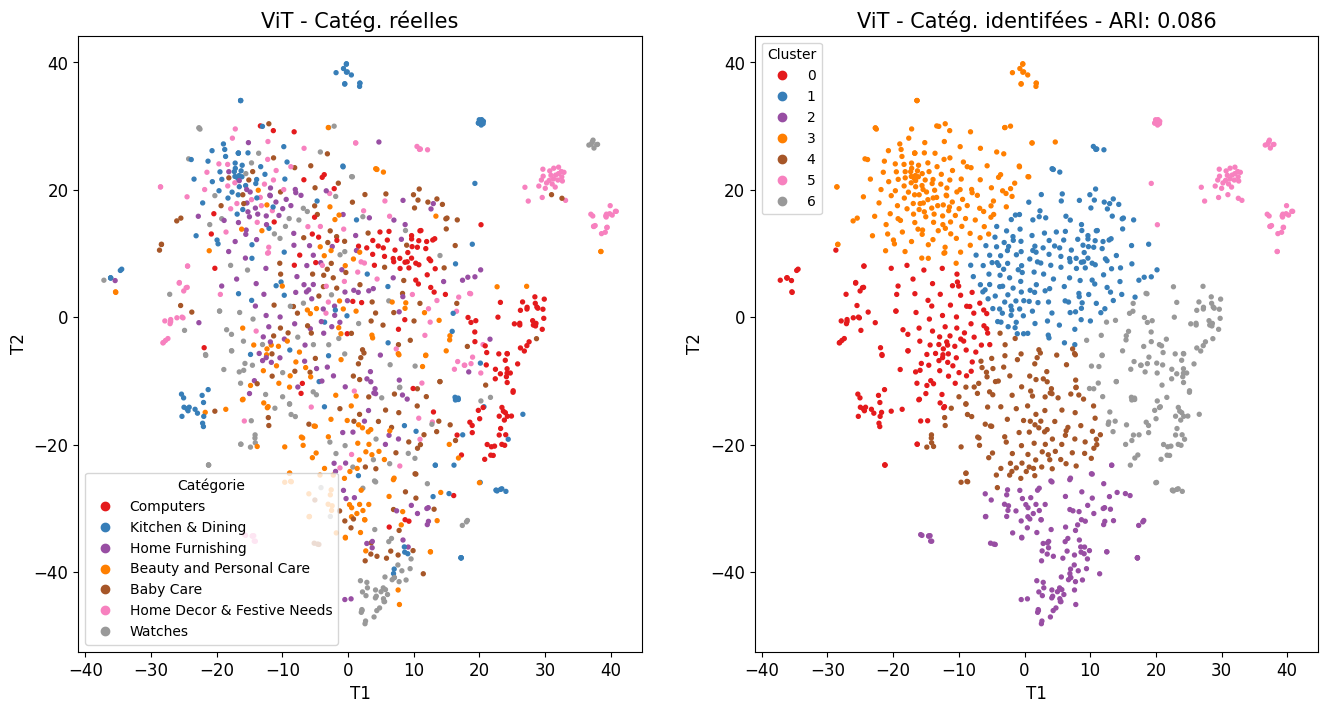

ARI : 0.0865


In [156]:
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
feature_extractor = 'ViT'
TSNE_visu_fct(X_tsne, l_cat, y_cat_num, labels, ARI, title_prefix=feature_extractor)

La featurisation n'est pas du tout concluante avec le transformes, et les images d'entraînement. 